# import the models from the config


In [52]:
import yaml
import importlib
import os
import joblib
import pickle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import os
import pickle
from sklearn.metrics import f1_score
import copy
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

IGNORE_WARNINGS = True


if IGNORE_WARNINGS:
    warnings.filterwarnings("ignore")





# Set the maximum width of the display for strings
pd.set_option('display.max_colwidth', 30)



def load_models_from_config(config_file):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    
    models = {}
    for model_name, model_config in config['models'].items():
        steps = []
        for step_config in model_config['steps']:
            module = importlib.import_module(step_config['module'])
            class_ = getattr(module, step_config['class'])
            if 'strategy' in step_config:
                step = (step_config['name'], class_(strategy=step_config['strategy']))
            else:
                step = (step_config['name'], class_())
            steps.append(step)

          # Add random seed if present in the config
        if 'random_seed' in model_config:
            random_seed = model_config['random_seed']
            for step_name, step_obj in steps:
                if hasattr(step_obj, 'random_state'):
                    step_obj.set_params(random_state=random_seed)

        # Add GridSearchCV if present in the config
        if 'grid_search' in model_config:
            param_grid = model_config['grid_search']['param_grid']
            cv = model_config['grid_search']['cv']
            scoring = model_config['grid_search']['scoring']
            grid_search = GridSearchCV(Pipeline(steps), param_grid, cv=cv, scoring=scoring)
            models[model_name] = grid_search
        else:
            models[model_name] = Pipeline(steps)
    
    
    return models

# Load models from YAML configuration
models = load_models_from_config('models_config.yaml')


In [53]:
models

{'Decision Tree': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('classifier', DecisionTreeClassifier(random_state=42))]),
 'Logistic Regression': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('classifier', LogisticRegression(random_state=42))]),
 'KNN': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('classifier', KNeighborsClassifier())]),
 'SVM': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('classifier', SVC(random_state=42))])}

# Train the models

In [54]:

# Path to the train data folder
train_data_folder = 'data/train'

# Create a dictionary to store trained models
trained_models = {}

# Iterate over files in train data folder
for filename in os.listdir(train_data_folder):
    file_path = os.path.join(train_data_folder, filename)
    
    # Load data from .pkl file
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        X_train, y_train = data.drop(columns='classes'), data['classes'].astype("category")
    
    # Iterate over models
    for model_name, model_pipeline in models.items():
        # Create a copy of the model pipeline
        model = copy.deepcopy(model_pipeline)
    
        # Train model
        model.fit(X_train, y_train)
        
        # Save trained model in dictionary with keys based on filename and model name
        key = f'{filename}_{model_name}'
        trained_models[key] = model
    


In [ ]:
# Path to the testing data folder
test_data_folder = 'data/test'

# Dictionary to store F1 micro scores for each model
f1_scores = {}

res = []

# Iterate over files in test data folder
for filename in os.listdir(test_data_folder):
    file_path = os.path.join(test_data_folder, filename)
    
    # Load data from .pkl file
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        X_test, y_test = data.drop(columns='classes'), data['classes'].astype("category")
    
    # Extract model name from the filename
    model_name, _ = filename.split('.pkl')
    model_name, _ = (model_name + '|').split('|')
    
    # Get the trained model corresponding to the model name
    model_keys = [key for key in trained_models if key.startswith(model_name)]

    for model_key in model_keys:

        model = trained_models.get(model_key)
        
        # Predict labels using the model
        y_pred = model.predict(X_test)
        
        # Calculate F1 micro score
        f1_micro = f1_score(y_test, y_pred, average='micro')
        
        res.append([model_key, f1_micro])



In [ ]:
df = pd.DataFrame(res,columns=['name', 'f1_micro'])


df[['dataset','model']] = df['name'].str.split('.pkl_', expand=True)
df[['dataset','pollution']] = df['dataset'].str.split('|', expand=True)

df = df.fillna(0)

In [ ]:
def sort_df(df):
    return df.sort_values(by=['completeness', 'accuracy', 'dupp_fac'], ascending=True, na_position='first')


In [ ]:
# Extracting coefficients into separate columns
df['completeness'] = df['pollution'].str.extract(r'completness_pollution_([0-9.]+)')
df['accuracy'] = df['pollution'].str.extract(r'feature_accuracy_pollution_([0-9.]+)')
df['dupp_fac'] = df['pollution'].str.extract(r'duplicate_factor_([0-9]+)')

# Converting columns to appropriate data types
df['completeness'] = df['completeness'].astype(float)
df['accuracy'] = df['accuracy'].astype(float)
df['dupp_fac'] = df['dupp_fac'].astype(float)


# Ordering the DataFrame based on the columns
df =  sort_df(df)

In [ ]:
df.pollution.unique()

array([0, 'duplicate_factor_3', 'duplicate_factor_5',
       'duplicate_factor_7', 'feature_accuracy_pollution_0.2',
       'feature_accuracy_pollution_0.4', 'feature_accuracy_pollution_0.6',
       'completness_pollution_0.2',
       'duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.2_random_seed_42',
       'duplicate_factor_5_completness_pollution_0.2_feature_accuracy_pollution_0.2_random_seed_42',
       'duplicate_factor_7_completness_pollution_0.2_feature_accuracy_pollution_0.2_random_seed_42',
       'duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.4_random_seed_42',
       'duplicate_factor_5_completness_pollution_0.2_feature_accuracy_pollution_0.4_random_seed_42',
       'duplicate_factor_7_completness_pollution_0.2_feature_accuracy_pollution_0.4_random_seed_42',
       'duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.6_random_seed_42',
       'duplicate_factor_5_completness_pollution_0.2_feature_accu

In [ ]:
# Apply group by and assign an index representing the order within each group
df['pollution_level'] = df.groupby(['dataset', 'model']).cumcount()

# Apply diff within each group
df['diff'] = df.groupby(['dataset', 'model'])['f1_micro'].diff()

pol_col = df[['completeness', 'accuracy', 'dupp_fac']].columns
df_col = df.columns

In [ ]:
pol_col = df[['completeness', 'accuracy', 'dupp_fac']].columns
df_col = df.columns

# expariment variables Table 
Indepndat variables are the detasets and the polution given to the dependat variable is a f1-micro score.

the datasets:
* hypercube
* shapes
* threenorm
* waveform
* xor
* spirals
* iris
* breast cancer
* wine

The parameters for the synthetic data creation is specified in the 

pollution_parameters:
* duplicate_factor: [3, 5, 7]
* completness_pollution: [0.2, 0.4, 0.6]
* feature_accuracy_pollution: [0.2, 0.4, 0.6]

every combination the independent varibables are combined in every way possible

I define non linear pollution level in order to vizulaize the data here is the table of the approprite level and its explenation:

| Index | Value                                                                                                                              |
|-------|------------------------------------------------------------------------------------------------------------------------------------|
| 0     | no pollution applied                                                                                                                                  |
| 1     | duplicate_factor_3                                                                                                                 |
| 2     | duplicate_factor_5                                                                                                                 |
| 3     | duplicate_factor_7                                                                                                                 |
| 4     | feature_accuracy_pollution_0.2                                                                                                     |
| 5     | feature_accuracy_pollution_0.4                                                                                                     |
| 6     | feature_accuracy_pollution_0.6                                                                                                     |
| 7     | completness_pollution_0.2                                                                                                          |
| 8     | duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.2                                                    |
| 9     | duplicate_factor_5_completness_pollution_0.2_feature_accuracy_pollution_0.2                                                    |
| 10    | duplicate_factor_7_completness_pollution_0.2_feature_accuracy_pollution_0.2                                                    |
| 11    | duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.4                                                    |
| 12    | duplicate_factor_5_completness_pollution_0.2_feature_accuracy_pollution_0.4                                                    |
| 13    | duplicate_factor_7_completness_pollution_0.2_feature_accuracy_pollution_0.4                                                    |
| 14    | duplicate_factor_3_completness_pollution_0.2_feature_accuracy_pollution_0.6                                                    |
| 15    | duplicate_factor_5_completness_pollution_0.2_feature_accuracy_pollution_0.6                                                    |
| 16    | duplicate_factor_7_completness_pollution_0.2_feature_accuracy_pollution_0.6                                                    |
| 17    | completness_pollution_0.4                                                                                                          |
| 18    | duplicate_factor_3_completness_pollution_0.4_feature_accuracy_pollution_0.2                                                    |
| 19    | duplicate_factor_5_completness_pollution_0.4_feature_accuracy_pollution_0.2                                                    |
| 20    | duplicate_factor_7_completness_pollution_0.4_feature_accuracy_pollution_0.2                                                    |
| 21    | duplicate_factor_3_completness_pollution_0.4_feature_accuracy_pollution_0.4                                                    |
| 22    | duplicate_factor_5_completness_pollution_0.4_feature_accuracy_pollution_0.4                                                    |
| 23    | duplicate_factor_7_completness_pollution_0.4_feature_accuracy_pollution_0.4                                                    |
| 24    | duplicate_factor_3_completness_pollution_0.4_feature_accuracy_pollution_0.6                                                    |
| 25    | duplicate_factor_5_completness_pollution_0.4_feature_accuracy_pollution_0.6                                                    |
| 26    | duplicate_factor_7_completness_pollution_0.4_feature_accuracy_pollution_0.6                                                    |
| 27    | completness_pollution_0.6                                                                                                          |
| 28    | duplicate_factor_3_completness_pollution_0.6_feature_accuracy_pollution_0.2                                                    |
| 29    | duplicate_factor_5_completness_pollution_0.6_feature_accuracy_pollution_0.2                                                    |
| 30    | duplicate_factor_7_completness_pollution_0.6_feature_accuracy_pollution_0.2                                                    |
| 31    | duplicate_factor_3_completness_pollution_0.6_feature_accuracy_pollution_0.4                                                    |
| 32    | duplicate_factor_5_completness_pollution_0.6_feature_accuracy_pollution_0.4                                                    |
| 33    | duplicate_factor_7_completness_pollution_0.6_feature_accuracy_pollution_0.4                                                    |
| 34    | duplicate_factor_3_completness_pollution_0.6_feature_accuracy_pollution_0.6                                                    |
| 35    | duplicate_factor_5_completness_pollution_0.6_feature_accuracy_pollution_0.6                                                    |
| 36    | duplicate_factor_7_completness_pollution_0.6_feature_accuracy_pollution_0.6                                                    |


# results of the experiment

In bellow vizualizations you can find a perfromance differnce of f1 micro score and invidial performance for each dateset 
F1 micro differnce is diference in performance between levels ex. knn level 1  0.8 f1-micro ->  knn level 3 0.5 f1-micro = 0.3 in differnce of f1 micro scores between diferent levels of pollution


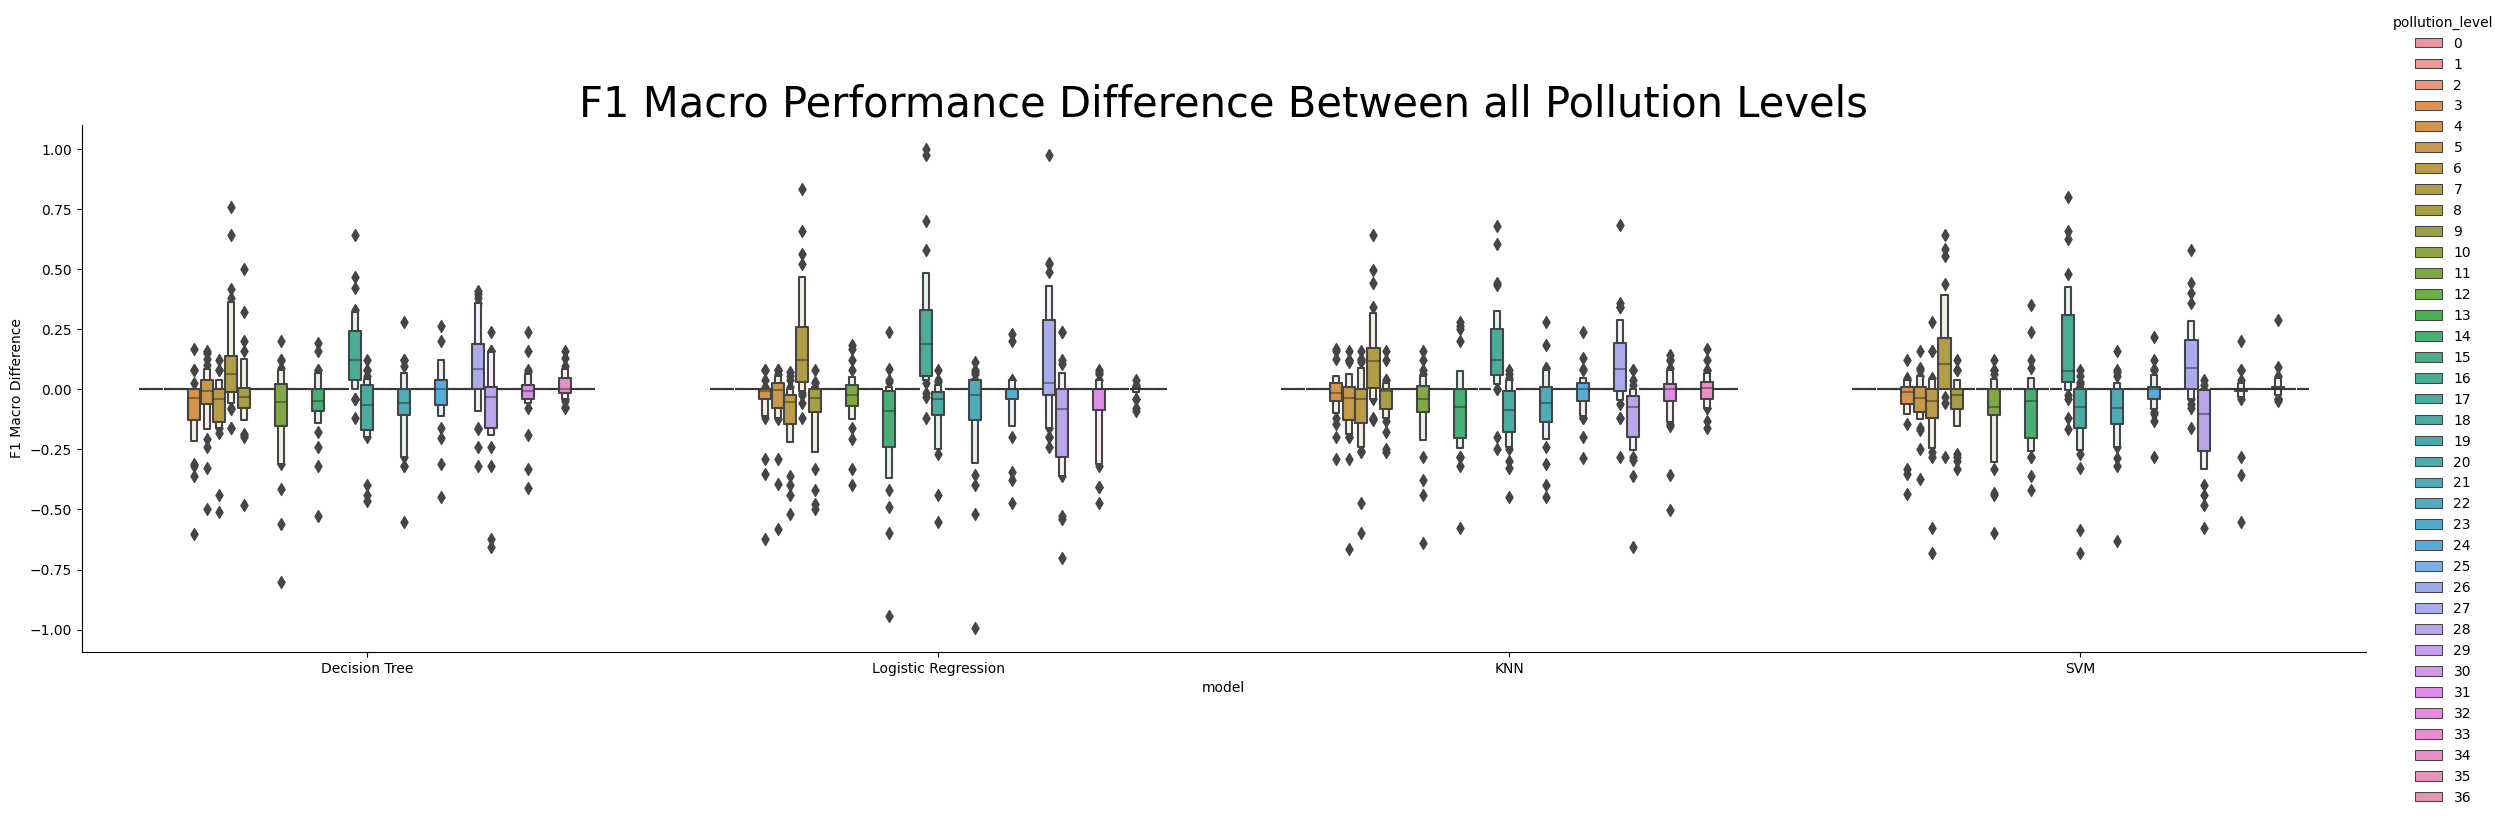

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already imported your DataFrame df
sns.catplot(data=df.fillna(0), x="model", y="diff", hue="pollution_level", kind="boxen", height=6, aspect=4)
plt.title('F1 Macro Performance Difference Between all Pollution Levels', fontsize=30)
plt.ylabel('F1 Macro Difference')
plt.show()


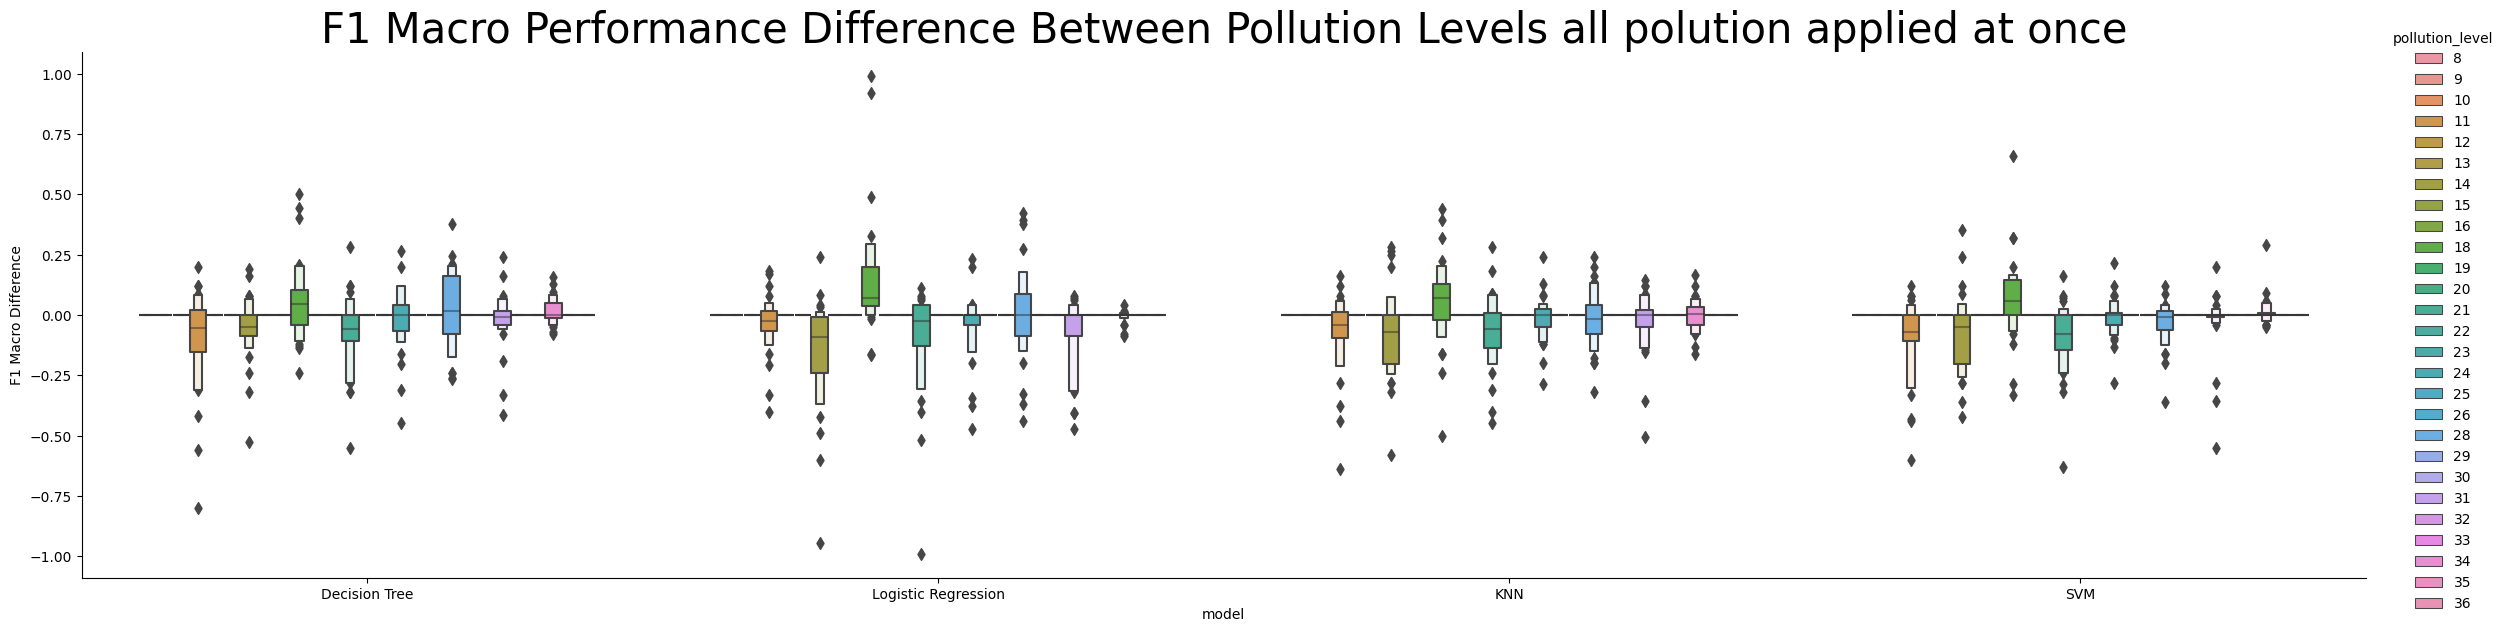

In [ ]:
data =df[~df[pol_col].isnull().any(axis=1)]
data['diff'] = data.groupby(['dataset', 'model'])['f1_micro'].diff()
# Assuming you have already imported your DataFrame df
sns.catplot(data=data.fillna(0), x="model", y="diff", hue="pollution_level", kind="boxen", height=6, aspect=4)

plt.title('F1 Macro Performance Difference Between Pollution Levels all polution applied at once', fontsize=30)
plt.ylabel('F1 Macro Difference')
plt.show()

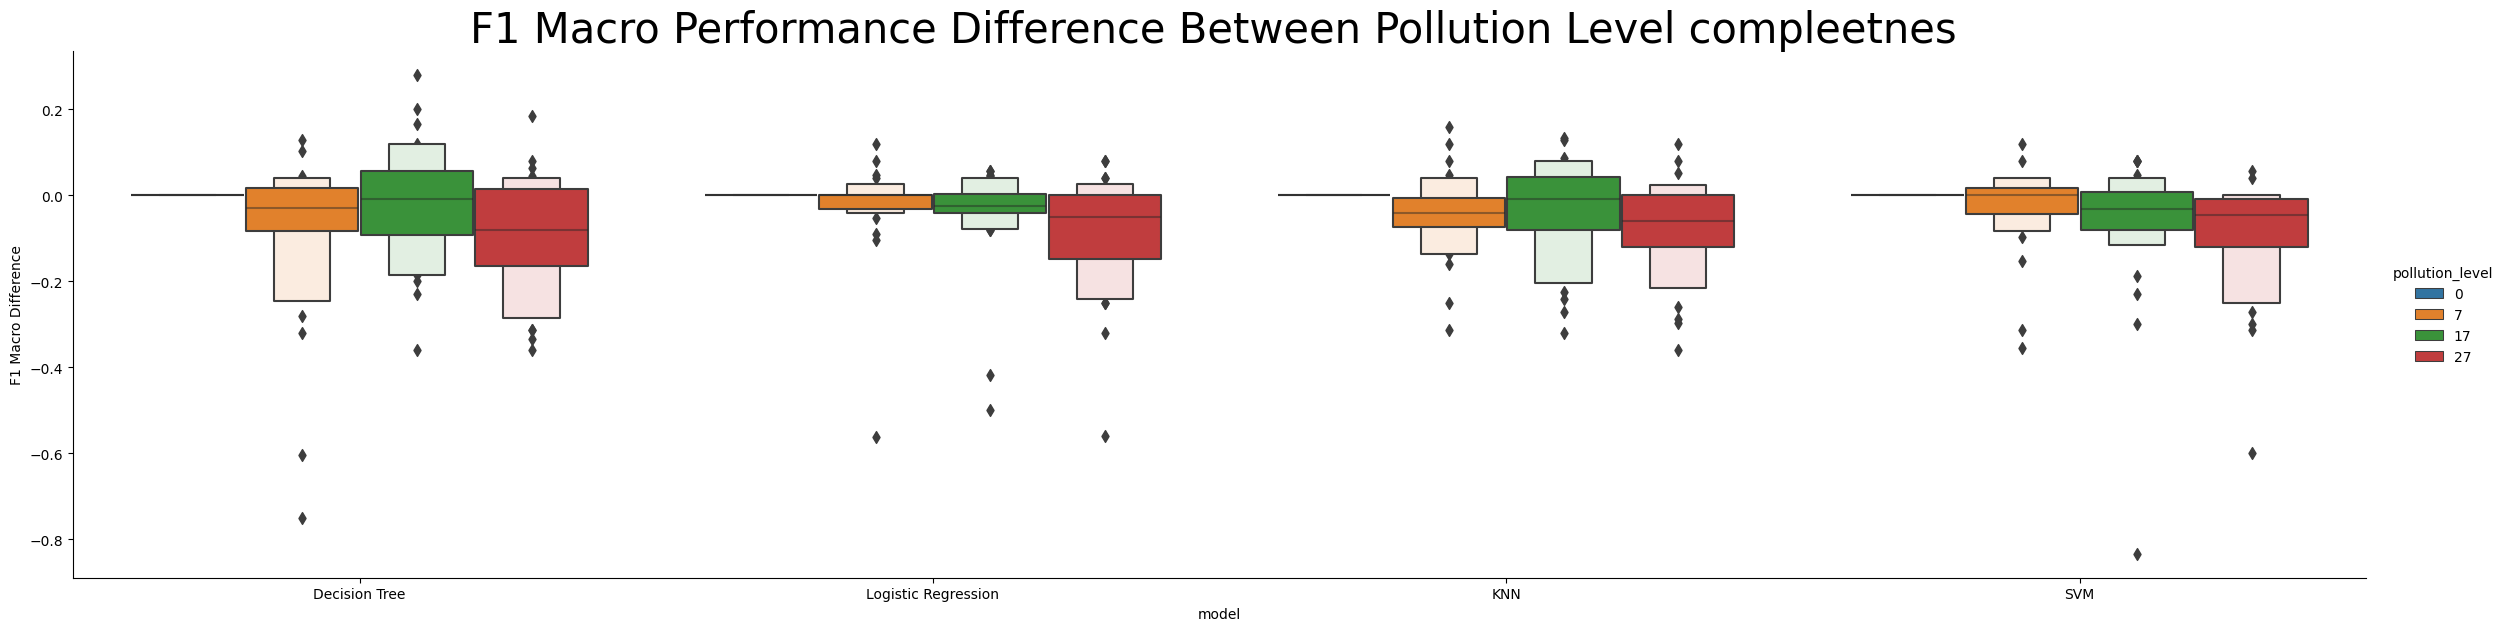

In [ ]:
data =df[df[pol_col.difference(['completeness'])].isnull().all(axis=1) | df[pol_col].isnull().all(axis=1)]
data['diff'] = data.groupby(['dataset', 'model'])['f1_micro'].diff()
# Assuming you have already imported your DataFrame df
sns.catplot(data=data.fillna(0), x="model", y="diff", hue="pollution_level", kind="boxen", height=6, aspect=4)

plt.title('F1 Macro Performance Difference Between Pollution Level compleetnes ', fontsize=30)
plt.ylabel('F1 Macro Difference')
plt.show()

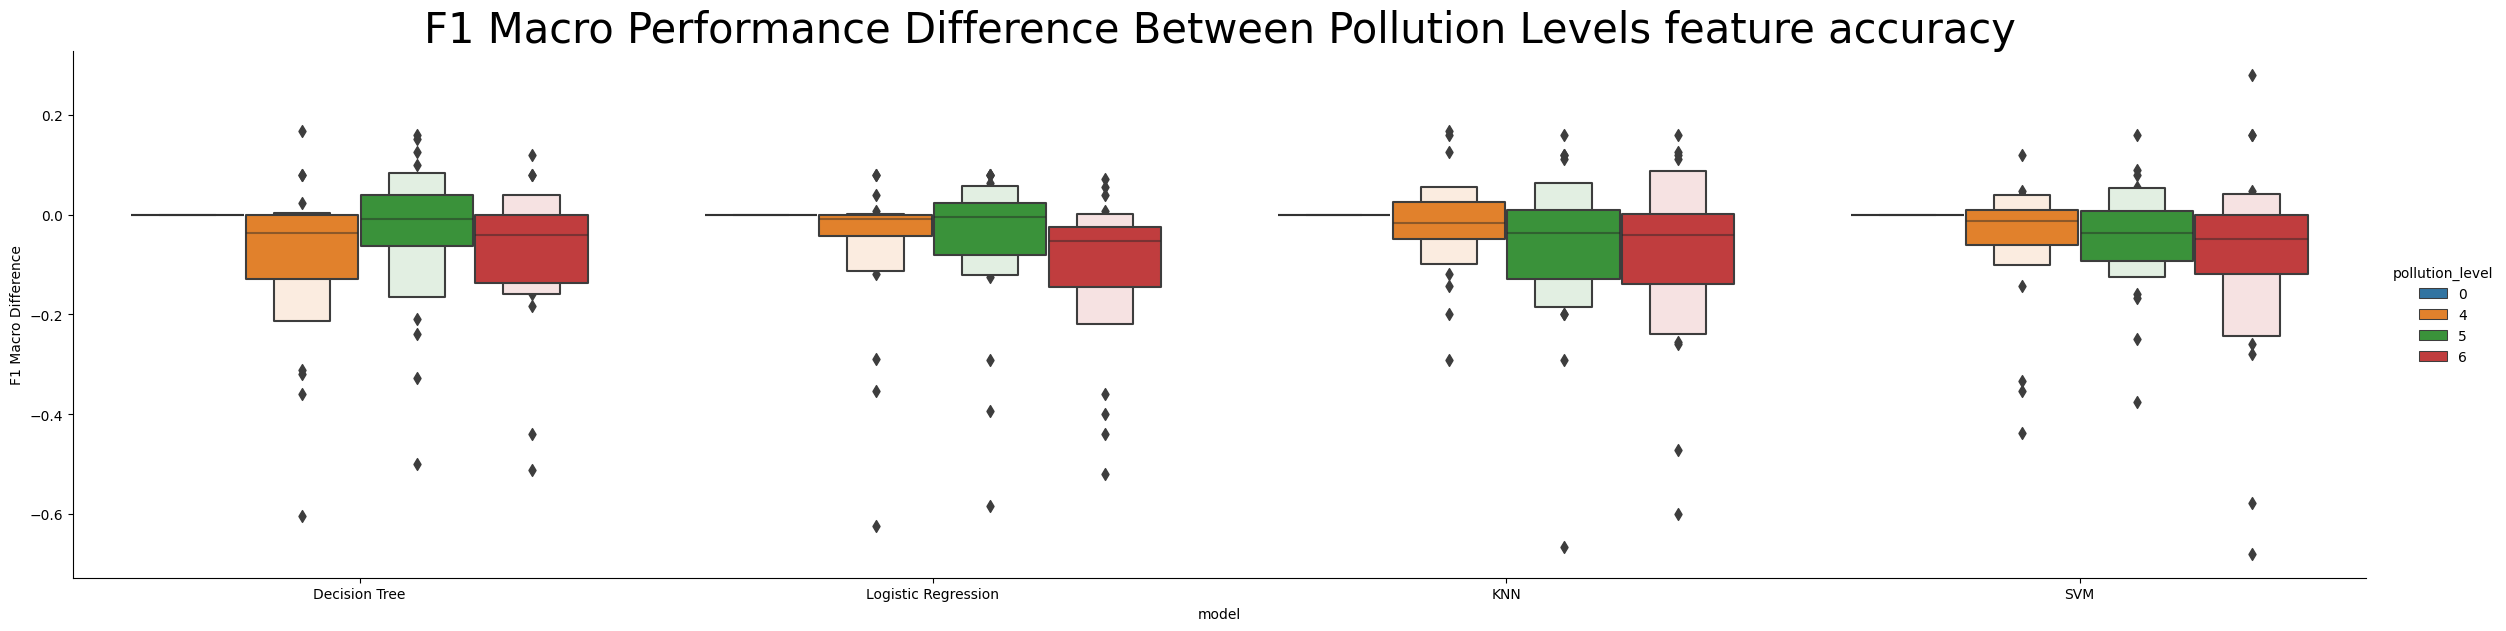

In [ ]:
data =df[df[pol_col.difference(['accuracy'])].isnull().all(axis=1) | df[pol_col].isnull().all(axis=1)]
data['diff'] = data.groupby(['dataset', 'model'])['f1_micro'].diff()
# Assuming you have already imported your DataFrame df
sns.catplot(data=data.fillna(0), x="model", y="diff", hue="pollution_level", kind="boxen", height=6, aspect=4)


plt.title('F1 Macro Performance Difference Between Pollution Levels feature accuracy', fontsize=30)
plt.ylabel('F1 Macro Difference')
plt.show()



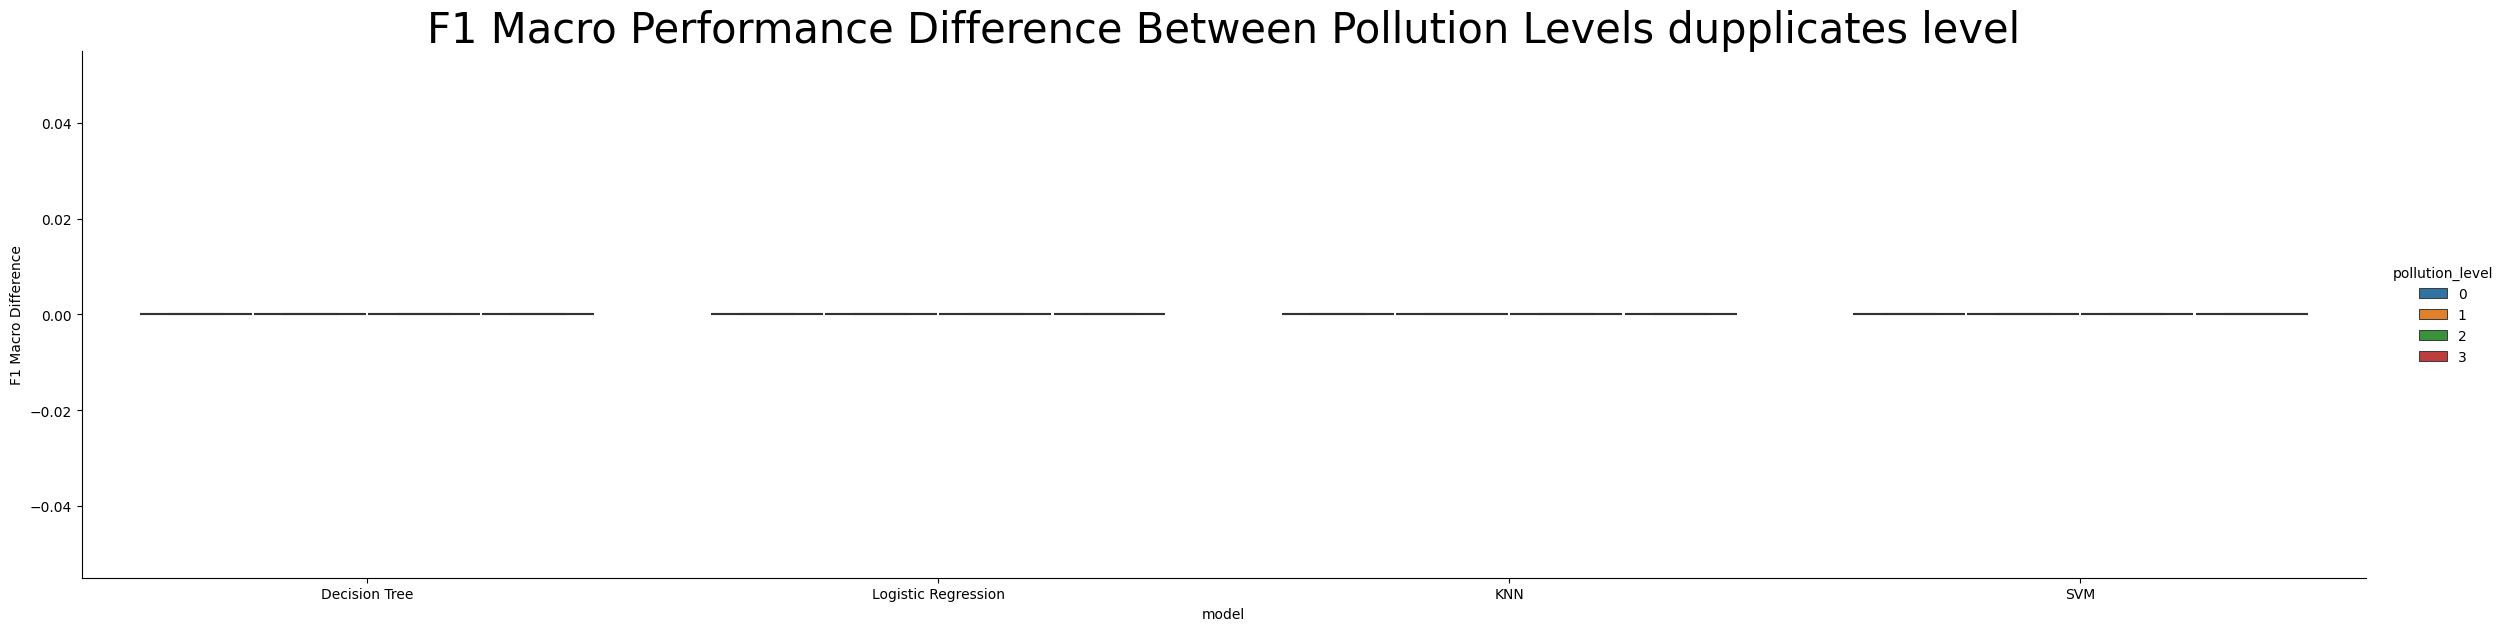

In [ ]:
data =df[df[pol_col.difference(['dupp_fac'])].isnull().all(axis=1) | df[pol_col].isnull().all(axis=1)]
data['diff'] = data.groupby(['dataset', 'model'])['f1_micro'].diff()
# Assuming you have already imported your DataFrame df
sns.catplot(data=data.fillna(0), x="model", y="diff", hue="pollution_level", kind="boxen", height=6, aspect=4)

plt.title('F1 Macro Performance Difference Between Pollution Levels dupplicates level', fontsize=30)
plt.ylabel('F1 Macro Difference')
plt.show()



In [ ]:
import pandas as pd
import plotly.express as px

groups = df.groupby('dataset')

for dataset, param in groups:
    param = sort_df(param)
    
    fig = px.line(param, x="pollution", y="f1_micro", color='model', title='effect of polution on performance dataset '+param.dataset.iloc[0])
    
    # Add labels and ticks for the x-axis
    fig.update_layout(xaxis=dict(title='Pollution Level', tickvals=list(range(38)), ticktext=list(range(38))))
    
    # Add label for the y-axis
    fig.update_layout(yaxis=dict(title='F1 Micro Score'))
    
    fig.show()
